In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import percentileofscore

In [2]:
def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df

def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_arome_run()

In [3]:
valid_run

9

In [4]:

def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&mode=8&sort=0'

    last_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        last_index_run = get_arome_data(url_run).index[-1]

        if last_index_run > last_index:
            last_index = last_index_run
            valid_run = run
        else:
            pass

    return valid_run


valid_run = get_last_arome_run()




aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')



aemet_horario_acumulado = pd.read_excel("Histórico/Acumulado.xlsx",index_col=0)
aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize('Europe/Madrid')

aemet_horario_acumulado = pd.concat([aemet_horario_acumulado,aemet_horario])

aemet_horario_acumulado = aemet_horario_acumulado[~aemet_horario_acumulado.index.duplicated(keep='first')]

aemet_horario_acumulado = aemet_horario_acumulado.sort_index(ascending=False)

aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize(None)

aemet_horario_acumulado.to_excel("Histórico/Acumulado.xlsx")

In [5]:
def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    print(url_run)

    return temp_data

In [6]:
temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0&run=9


<Axes: xlabel='Date'>

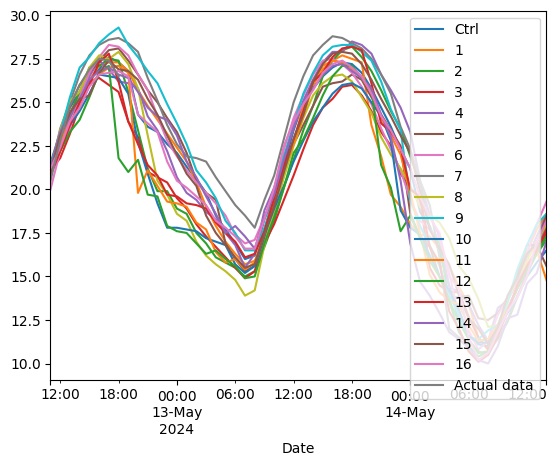

In [7]:
temp_data.plot()

In [8]:

def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data

def get_wind_gust_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=13&sort=0'
    url_run = f'{url}&run={valid_run}'

    wind_gust_data = get_arome_data(url_run)

    return wind_gust_data

def get_pressure_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=1&sort=0'
    url_run = f'{url}&run={valid_run}'

    pressure_data = get_arome_data(url_run)

    return pressure_data

def get_mucape_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=0&sort=0'
    url_run = f'{url}&run={valid_run}'

    mucape_data = get_arome_data(url_run)

    return mucape_data

def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


#####################################################

datos_df_global = pd.read_csv("retiro 1950.csv",index_col="fecha",parse_dates=True)

datos_df_global = datos_df_global[~((datos_df_global.index.month == 2) & (datos_df_global.index.day == 29) & datos_df_global.index.is_leap_year)]

datos_df_global['día_del_año'] = datos_df_global.index.day_of_year

es_bisiesto = datos_df_global.index.year % 4 == 0
es_bisiesto &= (datos_df_global.index.year % 100 != 0) | (datos_df_global.index.year % 400 == 0)
marzo_en_adelante = datos_df_global.index.month >= 3
datos_df_global.loc[es_bisiesto & marzo_en_adelante, 'día_del_año'] -= 1

temp_medias = datos_df_global[["día_del_año","tmed","tmax","tmin"]]
temp_medias = temp_medias.dropna(how="any")

temp_medias_rolling = temp_medias[["tmed","tmax","tmin"]].rolling(15,center=True).mean().dropna()
temp_medias_rolling["día del año"] = temp_medias_rolling.index.day_of_year

es_bisiesto = temp_medias_rolling.index.year % 4 == 0
es_bisiesto &= (temp_medias_rolling.index.year % 100 != 0) | (temp_medias_rolling.index.year % 400 == 0)
marzo_en_adelante = temp_medias_rolling.index.month >= 3
temp_medias_rolling.loc[es_bisiesto & marzo_en_adelante, 'día del año'] -= 1

temp_medias_rolling = temp_medias_rolling.groupby("día del año").quantile([0.15, 0.85]).unstack()

#####################################################

año_max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmax().year
año_min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmax().year

año_min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].idxmin().year
año_max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].idxmin().year

max_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].max()
min_maxima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].max()

min_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmin"].min()
max_minima = datos_df_global[datos_df_global["día_del_año"]==int(datetime.today().strftime("%j"))]["tmax"].min()

records_dia = pd.DataFrame(columns=["T. max","T. min"],index=["Record calor","Record frío"])
records_dia["T. max"] = ["{} ({})".format(max_maxima, año_max_maxima),"{} ({})".format(max_minima, año_max_minima)]
records_dia["T. min"] = ["{} ({})".format(min_maxima, año_min_maxima),"{} ({})".format(min_minima, año_min_minima)]
records_dia = records_dia.style.apply(lambda x: ['background-color: rgba(255, 204, 204, 0.4)' if x.name == 'T. max' else 'background-color: rgba(204, 204, 255, 0.4)' for i in x], 
                        axis=0, subset=pd.IndexSlice[:, ['T. max', 'T. min']])


#st.write(aemet_horario.index[0].strftime("%A %d %B %H:%M: "),str(aemet_horario["Temperatura (ºC)"].iloc[0])+"º")



temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

temp_actual = aemet_horario["Temperatura (ºC)"].iloc[0]
temp_ayer = aemet_horario.iloc[-1]["Temperatura (ºC)"]

dia_mañana = (datetime.now() + timedelta(hours=26)).day
hora = (datetime.now() + timedelta(hours=2)).hour

temp_mañana = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].mean(axis=1)[0].round(1)
desv_temp = temp_data.loc[temp_data.index[(temp_data.index.hour==hora) & (temp_data.index.day ==dia_mañana)]].std(axis=1).round(1)[0]

fiabilidad = 10*np.exp(-0.05*desv_temp**2.5)

In [9]:
def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


prec_data = get_prec_data(valid_run)
#prec_data["Actual data"] = aemet_horario["Precipitación (mm)"]

chance_prec = 100 * pd.DataFrame((prec_data.apply(lambda row: sum(row != 0), axis=1) / len(prec_data.columns)) )


def plot_prec_data(data):

        data = data

        # Set figure size and resolution
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

        # Set plot style
        plt.style.use('default')

        # Iterate over the columns and plot each one
        for column in data.columns[:-1]:
            ax.plot(data.index, data[column], alpha=0.9)
            #ax.plot(data.index,data[column].cumsum(),alpha=0.5,linestyle="--")

        #ax.plot(data["Actual data"], alpha=1,linewidth=4,color="black")

        # Add title and labels


        plt.title('Rain Forecast for the next 2 days', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('L/m2', fontsize=12)

       

        # Remove top and right spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Set x-axis tick parameters
        plt.xticks(fontsize=10, rotation=0, ha='right')

        # Set y-axis tick parameters
        plt.yticks(fontsize=10)

        # Add vertical lines for each hour
        for hour in data.index:
            ax.axvline(hour, linestyle='--', color='black', alpha=0.1)
       # for column in data.column:
        #    ax.axvline(dataa[column]



        # Rmove gridlines
        plt.grid(True)

        # Compute the minimum and maximum temperature for each day and their respective indexes
        dates = list(set(data.index.date))
        min_temps = []
        max_temps = []
        min_idx = []
        max_idx = []

        for date in dates:
            df = data.loc[data.index.date == date]
            min_temp = df.min().min()
            max_temp = df.max().max()
            min_idx.append(data.loc[data.index.date == date].idxmin().min())
            max_idx.append(data.loc[data.index.date == date].idxmax().min())
            min_temps.append(min_temp)
            max_temps.append(max_temp)

        # Add the minimum temperature text to the plot
        #for i, temp in enumerate(min_temps):
         #   min_temp = "{:.1f}".format(temp)
         #   ax.text(min_idx[i], temp, min_temp, ha='left', va='top', color='blue',fontweight="bold")

        # Add the maximum temperature text to the plot
        for i, temp in enumerate(max_temps):
            max_temp = "{:.1f}".format(temp)
            ax.text(max_idx[i], temp, max_temp, ha='left', va='bottom', color='red',fontweight="bold")


        # Format x-axis ticks
        # Format x-axis ticks
        ticks = []
        tick_labels = []
        for date in data.index:
                if date.hour == 0:
                    tick_labels.append(date.strftime('%a, %b %d'))
                    ticks.append(date)
                    ax.axvline(date,0,1,color="black",linewidth=2)
                if date.hour % 6 == 0:
                    tick_labels.append(date.strftime('%H'))
                    ticks.append(date)
                    pass

        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center')

        ax.set_ylim(bottom=0)

        return 

#st.write(prec_data)

#plot_prec_data(chance_prec)

In [10]:
avg_prec = []
for i in range(len(prec_data)):

    try:
        avg_prec.append(sum(prec_data.iloc[i][prec_data.iloc[i]!=0])/len(prec_data.iloc[i][prec_data.iloc[i]!=0]))

    except:
        avg_prec.append(0)

avg_prec = pd.DataFrame(avg_prec)
avg_prec = avg_prec.round(1)
avg_prec.index = prec_data.index

In [11]:
def plot_rain_chance(chance_prec,avg_prec):

    chance_prec = chance_prec 
    avg_prec = avg_prec 
    
    fig, axs = plt.subplots(2,gridspec_kw={'height_ratios': [0.5,0.5]},figsize=(10, 10),sharex=True) 

    axs[1].bar(chance_prec.index, chance_prec.iloc[:,0],width=0.025)
    axs[1].set_ylim(bottom=0,top=100)


    axs[0].bar(avg_prec.index, avg_prec.iloc[:,0],width=0.025)

    ticks = []
    tick_labels = []
    for date in avg_prec.index:
            if date.hour == 0:
                tick_labels.append(date.strftime('%a, %b %d'))
                ticks.append(date)
                axs[0].axvline(date,0,1,color="black",linewidth=2)
                axs[1].axvline(date,0,1,color="black",linewidth=2)
            if date.hour % 6 == 0:
                tick_labels.append(date.strftime('%H'))
                ticks.append(date)
                pass

    for hour in avg_prec.index:
        axs[0].axvline(hour, linestyle='--', color='black', alpha=0.1)
        axs[1].axvline(hour, linestyle='--', color='black', alpha=0.1)

    axs[0].set_xticks(ticks)
    axs[0].set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center')

    axs[1].set_xticks(ticks)
    axs[1].set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center')

    axs[0].grid(True)
    axs[1].grid(True)

    plt.suptitle("Rain forecast",y=0.91)

    axs[0].set_ylabel('Average L/m2 in case of rain')
    axs[1].set_ylabel('Chance of rain')


    #axs[1].set_ylim(bottom=0,top=100)

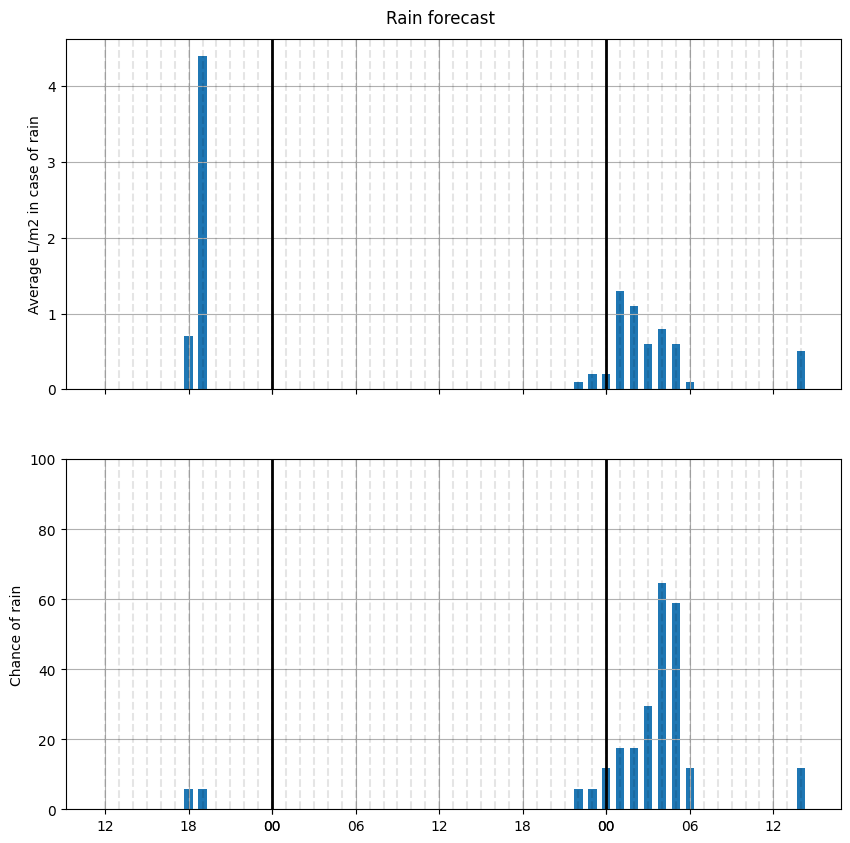

In [12]:
plot_rain_chance(chance_prec,avg_prec)

In [1]:
import astral
import datetime
from astral import LocationInfo
from astral.sun import sun
import pytz

madrid = LocationInfo("Madrid", "Spain", "Europe/Madrid", 40.41167, -3.67753)
listahoras = []

for i in range(0,24):
    listahoras.append(datetime.datetime(2024,5,10,i,0,0,tzinfo=pytz.timezone('Europe/Madrid')))

elevaciones = []

for i in listahoras:
    elevaciones.append(astral.sun.elevation(madrid.observer,i))


In [5]:
import astral
import datetime
from astral import LocationInfo
from astral.sun import sun
import pytz

In [16]:
%%timeit 



1.8 µs ± 6.05 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [11]:
datetime.datetime.year()

TypeError: 'getset_descriptor' object is not callable

In [40]:
madrid = LocationInfo("Madrid", "Spain", "Europe/Madrid", 40.41167, -3.67753)


today = datetime.datetime.now(tz=pytz.timezone('Europe/Madrid'))
year = today.year
month = today.month
day = today.day

datetime.datetime.year

listahoras = []
for i in range(0,24*60):  # Generate datetime objects for every minute from 00:00 to 23:59
    listahoras.append(datetime.datetime(year,12,day,i//60, i%60, tzinfo=pytz.timezone('Europe/Madrid')))

elevaciones = []
for i in listahoras:
    elevaciones.append(astral.sun.elevation(madrid.observer, i))



def find_positive_and_negative_positions(lst):
    # Initialize position variables
    positive_position = None
    negative_position = None

    # Check if list is empty
    if len(lst) == 0:
        return None, None

    # Iterate over the list with index and value
    for i, num in enumerate(lst[1:], start=1):
        if lst[i-1] > 0:  # Check if previous number was positive
            if num < 0:  # Check if current number is negative
                negative_position = i + 1

        elif lst[i-1] < 0 and num >= 0:  # Check if previous number was negative
            positive_position = i + 1

    return positive_position, negative_position

positive_position, negative_position = find_positive_and_negative_positions(elevaciones)

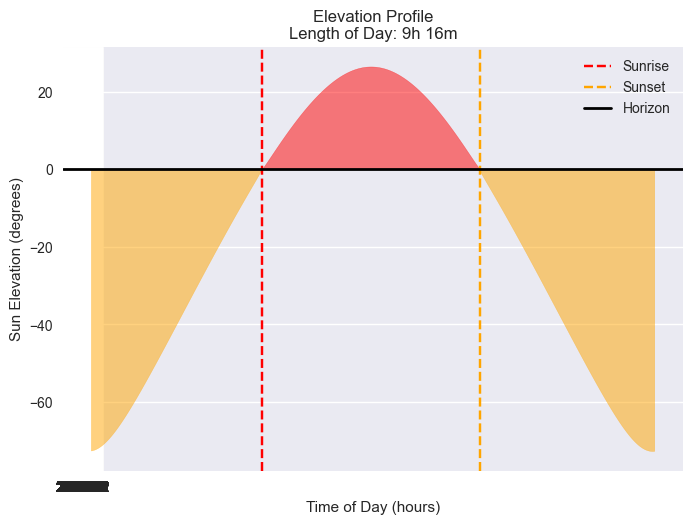

In [85]:
import matplotlib. pyplot as plt
import numpy as np

# Convert elevations list to numpy array for easier plotting
elevaciones_array = np.array(elevaciones)

# Create a filled area chart of sun elevation at each hour
plt.fill_between( np.arange(len(elevaciones)), elevaciones_array, where=elevaciones_array > 0, color='red', alpha=0.5)
plt.fill_between(np.arange(len(elevaciones)), elevaciones_array, where=elevaciones_array < 0, color='orange', alpha=0.5)

# Set the x-axis label and y-axis labels
plt.xlabel('Time of Day (hours)')
plt.ylabel('Sun Elevation (degrees)')

# Find the indices of sunrise and sunset positions in the elevations array
sunrise_index = positive_position
sunset_index = negative_position

# Create vertical lines for sunrise and sunset
plt.axvline(x=sunrise_index, color='red', linestyle='--', label='Sunrise')
plt.axvline(x=sunset_index, color='orange', linestyle='--', label='Sunset')

# Add a black line at the horizon (0 degrees elevation)
plt.axhline(y=0, color='black', linewidth=2, label='Horizon')

# Set the title and legend
plt.title(f'Elevation Profile\nLength of Day: {int((sunset_index - sunrise_index) / 60)}h {int((sunset_index - sunrise_index) % 60)}m')
plt.legend()

# Customize the plot appearance
plt.grid(True)

# Plot hours on x-axis with rounded values
hours = np.arange(0, len(elevaciones), 1) // 60
plt.xticks(elevaciones , [str(int(i)) for i in hours])

new_x = [hours[i] for i in [0, len(hours) // 2, -1]]

# Show the plot
plt.show()

In [89]:
new_x = [hours[i] for i in [0, len(hours) // 24, -1]]
new_x

[0, 1, 23]

In [70]:
[i / 60 for i in np.arange(0, len(elevaciones), 1)]

[0.0,
 0.016666666666666666,
 0.03333333333333333,
 0.05,
 0.06666666666666667,
 0.08333333333333333,
 0.1,
 0.11666666666666667,
 0.13333333333333333,
 0.15,
 0.16666666666666666,
 0.18333333333333332,
 0.2,
 0.21666666666666667,
 0.23333333333333334,
 0.25,
 0.26666666666666666,
 0.2833333333333333,
 0.3,
 0.31666666666666665,
 0.3333333333333333,
 0.35,
 0.36666666666666664,
 0.38333333333333336,
 0.4,
 0.4166666666666667,
 0.43333333333333335,
 0.45,
 0.4666666666666667,
 0.48333333333333334,
 0.5,
 0.5166666666666667,
 0.5333333333333333,
 0.55,
 0.5666666666666667,
 0.5833333333333334,
 0.6,
 0.6166666666666667,
 0.6333333333333333,
 0.65,
 0.6666666666666666,
 0.6833333333333333,
 0.7,
 0.7166666666666667,
 0.7333333333333333,
 0.75,
 0.7666666666666667,
 0.7833333333333333,
 0.8,
 0.8166666666666667,
 0.8333333333333334,
 0.85,
 0.8666666666666667,
 0.8833333333333333,
 0.9,
 0.9166666666666666,
 0.9333333333333333,
 0.95,
 0.9666666666666667,
 0.9833333333333333,
 1.0,
 1.0166

In [64]:
[str(int(i))[::60] for i in hours]

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2',
 '2'

In [59]:
hours = [i // 60 for i in np.arange(0, len(elevaciones), 1)]

In [60]:
hours

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,


In [53]:
[str(int(i))[:2] for i in hours]

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '10',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '11',
 '12',
 '12',
 '12',
 '12',
 '12',
 '12',
 '12',
 '12',
 '12',
 '12',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '13',
 '14',
 '14',
 '14',
 '14',
 '

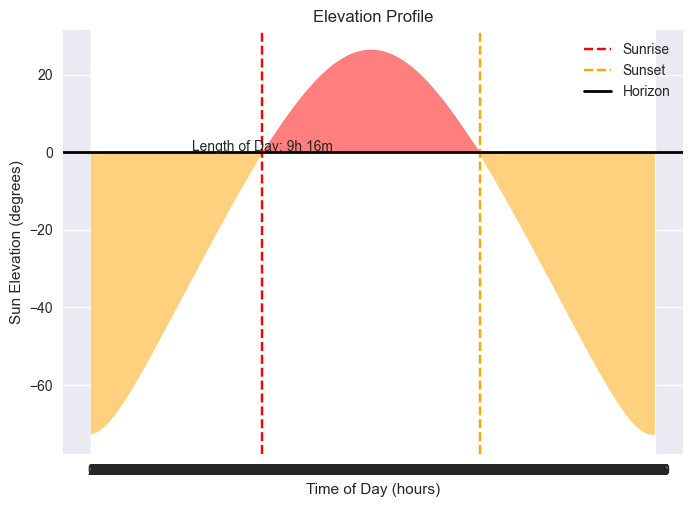

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Convert elevations list to numpy array for easier plotting
elevaciones_array = np.array(elevaciones)

# Create a filled area chart of sun elevation at each hour
plt.fill_between(range(len(elevaciones)), elevaciones_array, where=elevaciones_array > 0, color='red', alpha=0.5)
plt.fill_between(range(len(elevaciones)), elevaciones_array, where=elevaciones_array < 0, color='orange', alpha=0.5)

# Set the x-axis label and y-axes labels
plt.xlabel('Time of Day (hours)')
plt.ylabel('Sun Elevation (degrees)')

# Find the indices of sunrise and sunset positions in the elevations array
sunrise_index = positive_position
sunset_index = negative_position

# Create vertical lines for sunrise and sunset
plt.axvline(x=sunrise_index, color='red', linestyle='--', label='Sunrise')
plt.axvline(x=sunset_index, color='orange', linestyle='--', label='Sunset')

# Add a black line at the horizon (0 degrees elevation)
plt.axhline(y=0, color='black', linewidth=2, label='Horizon')

# Set the title and legend
plt.title('Elevation Profile')
plt.legend()

# Customize the plot appearance
plt.grid(True)

# Set x-axis ticks to show hours
plt.xticks(np.arange(0, len(elevaciones), 1))

# Calculate the length of the day in hours and minutes
length_of_day = sunset_index - sunrise_index
hours = int(length_of_day / 60)
minutes = int(length_of_day % 60)

# Add a text label to show the length of the day
plt.text(sunrise_index + 0.5, elevaciones_array[sunrise_index] * 1.1, f'Length of Day: {hours}h {minutes}m', ha='center')

# Show the plot
plt.show()

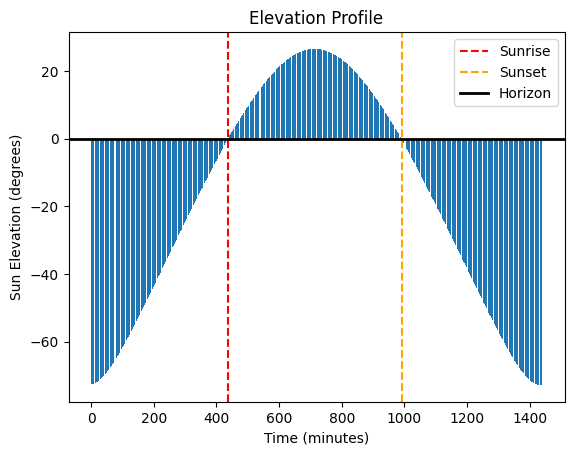

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Convert elevations list to numpy array for easier plotting
elevaciones_array = np.array(elevaciones)

# Create a bar chart of sun elevation at each minute
plt.bar(range(len(elevaciones)), elevaciones_array)
plt.xlabel('Time (minutes)')
plt.ylabel('Sun Elevation (degrees)')

# Find the indices of sunrise and sunset positions in the elevations array
sunrise_index = positive_position
sunset_index = negative_position

# Create vertical lines for sunrise and sunset
plt.axvline(x=sunrise_index, color='red', linestyle='--', label='Sunrise')
plt.axvline(x=sunset_index, color='orange', linestyle='--', label='Sunset')

# Add a black line at the horizon (0 degrees elevation)
plt.axhline(y=0, color='black', linewidth=2, label='Horizon')

# Add legend and title
plt.legend()
plt.title('Elevation Profile')
plt.show()

<Axes: >

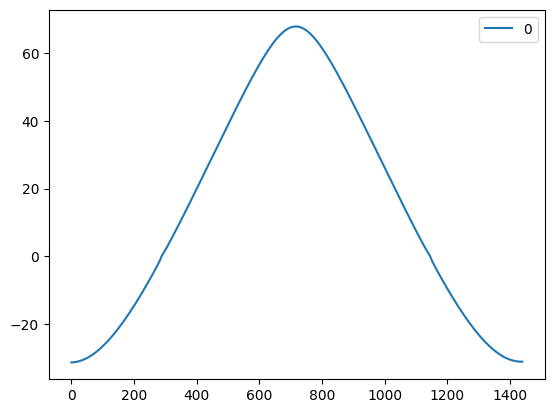

In [23]:
import pandas as pd 

pd.DataFrame(elevaciones).plot()

In [ ]:
listahoras

[datetime.datetime(2024, 5, 10, 0, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 1, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 2, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 3, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 4, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 5, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 6, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 7, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 8, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.datetime(2024, 5, 10, 9, 0, tzinfo=<DstTzInfo 'Europe/Madrid' LMT-1 day, 23:45:00 STD>),
 datetime.

In [ ]:
from astral.sun import elevation

elevation(madrid.observer,fechahora)

-13.929204589564435

(0.0, 100.0)

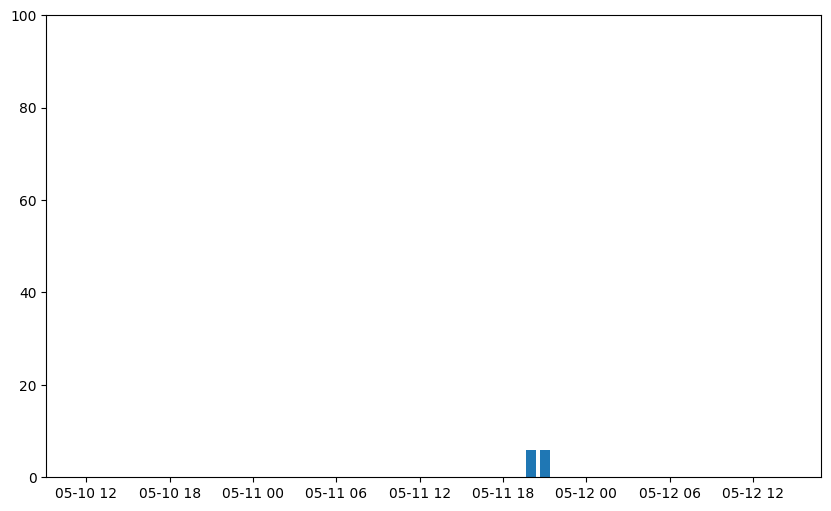

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

#ax.bar(chance_prec)

ax.bar(chance_prec.index, chance_prec.iloc[:,0],width=0.031)
ax.set_ylim(bottom=0,top=100)



<Axes: xlabel='Date'>

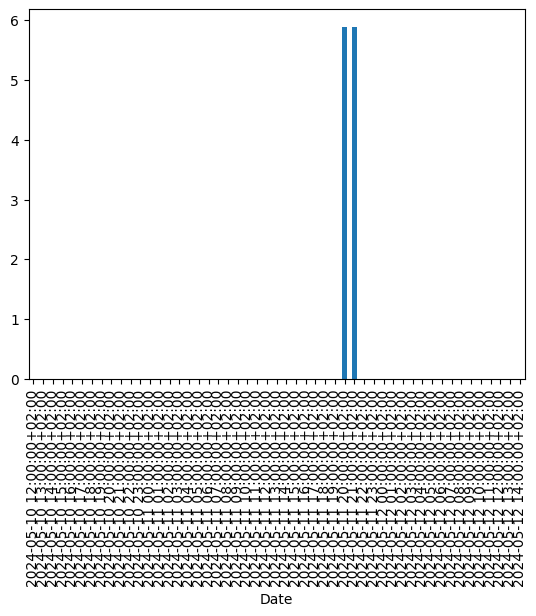

In [ ]:
chance_prec = (prec_data.apply(lambda row: sum(row != 0), axis=1) / len(prec_data.columns)) * 100

chance_prec.plot.bar()

In [ ]:
prec_data.apply(lambda row: sum(row != 0), axis=1)

Date
2024-05-10 12:00:00+02:00    0
2024-05-10 13:00:00+02:00    0
2024-05-10 14:00:00+02:00    0
2024-05-10 15:00:00+02:00    0
2024-05-10 16:00:00+02:00    0
2024-05-10 17:00:00+02:00    0
2024-05-10 18:00:00+02:00    0
2024-05-10 19:00:00+02:00    0
2024-05-10 20:00:00+02:00    0
2024-05-10 21:00:00+02:00    0
2024-05-10 22:00:00+02:00    0
2024-05-10 23:00:00+02:00    0
2024-05-11 00:00:00+02:00    0
2024-05-11 01:00:00+02:00    0
2024-05-11 02:00:00+02:00    0
2024-05-11 03:00:00+02:00    0
2024-05-11 04:00:00+02:00    0
2024-05-11 05:00:00+02:00    0
2024-05-11 06:00:00+02:00    0
2024-05-11 07:00:00+02:00    0
2024-05-11 08:00:00+02:00    0
2024-05-11 09:00:00+02:00    0
2024-05-11 10:00:00+02:00    0
2024-05-11 11:00:00+02:00    0
2024-05-11 12:00:00+02:00    0
2024-05-11 13:00:00+02:00    0
2024-05-11 14:00:00+02:00    0
2024-05-11 15:00:00+02:00    0
2024-05-11 16:00:00+02:00    0
2024-05-11 17:00:00+02:00    0
2024-05-11 18:00:00+02:00    0
2024-05-11 19:00:00+02:00    0
202

In [ ]:
prec_data

,Ctrl,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Date,,,,,,,,,,,,,,,,,
2024-05-10 12:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 13:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 14:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 15:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 16:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 17:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 18:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 19:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 20:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
########################################################

día_año_hoy = (datetime.now()+timedelta(hours=2)).timetuple().tm_yday

día_año_mañana = día_año_hoy + 1 #(datetime.now()+timedelta(hours=0)).timetuple().tm_yday

hora_día = (datetime.now()+timedelta(hours=2)).hour



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_hoy]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min = temp_data[temp_data.index.day_of_year==día_año_hoy].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_hoy = percentileofscore(arr_max, valor_max)

percentil_min_hoy = percentileofscore(arr_min, valor_min)



# Definir el array de valores
arr_max = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmax"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_max_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).max().round(1)


# Definir el array de valores
arr_min = datos_df_global[datos_df_global["día_del_año"]==día_año_mañana]["tmin"].sort_values().dropna()

# Definir el valor para el cual deseas calcular el percentil
valor_min_mañana = temp_data[temp_data.index.day_of_year==día_año_mañana].mean(axis=1).min().round(1)

# Calcular el percentil

percentil_max_mañana = percentileofscore(arr_max, valor_max_mañana)

percentil_min_mañana = percentileofscore(arr_min, valor_min_mañana)


In [ ]:
texto_percentil = "El percentil indica cómo es la temperatura frente a los registros históricos, un valor cercano a 100 indica un registro extremadamente alto, uno cercano a 0 indica un registro extremadamente bajo."


if hora_día < 9:

    col1,col2,col3,col4 = st.columns(4,gap="small")

    col1.metric(":thermometer: Mínima hoy (ºC)",valor_min,int(percentil_min_hoy.round(0)),delta_color="off",help=texto_percentil)
    col2.metric(":thermometer: Máxima hoy (ºC)",valor_max,int(percentil_max_hoy.round(0)),delta_color="off",help=texto_percentil)
    col3.metric(":thermometer: Mínima mañana (ºC)",valor_min_mañana,int(percentil_min_mañana.round(0)),delta_color="off",help=texto_percentil)
    col4.metric(":thermometer: Máxima mañana (ºC)",valor_max_mañana,int(percentil_max_mañana.round(0)),delta_color="off",help=texto_percentil)


else:
    col1,col2,col3 = st.columns(3,gap="small")
    
    col1.metric(":thermometer: Máxima hoy (ºC)",valor_max,int(percentil_max_hoy.round(0)),delta_color="off",help=texto_percentil)
    col2.metric(":thermometer: Mínima mañana (ºC)",valor_min_mañana,int(percentil_min_mañana.round(0)),delta_color="off",help=texto_percentil)
    col3.metric(":thermometer: Máxima mañana (ºC)",valor_max_mañana,int(percentil_max_mañana.round(0)),delta_color="off",help=texto_percentil)


2024-05-10 20:12:55.665 
  command:

    streamlit run C:\Users\Iván\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [ ]:
prec_data

,Ctrl,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Date,,,,,,,,,,,,,,,,,
2024-05-10 12:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 13:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 14:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 15:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 16:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 17:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 18:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 19:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-10 20:00:00+02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = pd.read_json("https://api.open-meteo.com/v1/forecast?latitude=40.41&longitude=-3.659&hourly=temperature_2m,precipitation,pressure_msl,cloudcover,windspeed_10m,windgusts_10m,cape&current_weather=true&timezone=Europe%2FBerlin&past_days=1&models=ecmwf_ifs04,gfs_global,icon_eu,meteofrance_arpege_europe,meteofrance_arome_france_hd")

In [ ]:
data.iloc[6:,-1].sort_index()

cape_ecmwf_ifs04                              [None, None, None, None, None, None, None, Non...
cape_gfs_global                               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
cape_icon_eu                                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
cape_meteofrance_arome_france_hd              [0.0, 0.0, 20.0, 40.0, 30.0, 60.0, 50.0, 40.0,...
cape_meteofrance_arpege_europe                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
cloudcover_ecmwf_ifs04                        [1, 2, 4, 5, 6, 9, 16, 24, 30, 32, 31, 30, 30,...
cloudcover_gfs_global                         [5, 10, 6, 12, 12, 57, 10, 15, 51, 100, 100, 1...
cloudcover_icon_eu                            [0, 0, 0, 24, 0, 7, 56, 16, 57, 38, 80, 100, 1...
cloudcover_meteofrance_arome_france_hd        [None, None, None, None, None, None, None, Non...
cloudcover_meteofrance_arpege_europe          [13, 13, 31, 43, 71, 54, 50, 98, 99, 87, 87, 9...
precipitation_ecmwf_ifs04               

In [ ]:
nombre_cape = "cape_"
nombre_nubes = "cloudcover_"
nombre_preci = "precipitation_"
nombre_presion = "pressure_msl_"
nombre_temp = "temperature_2m_"
nombre_rachas = "windgusts_10m_"
nombre_viento = "windspeed_10m_"


In [ ]:
modelo_gfs = "gfs_global"
modelo_europeo = "ecmwf_ifs04"
modelo_icon = "icon_eu"
modelo_arome = "meteofrance_arome_france_hd"
modelo_arpege = "meteofrance_arpege_europe"

In [ ]:

time = data.loc["time"]["hourly"]

<Axes: >

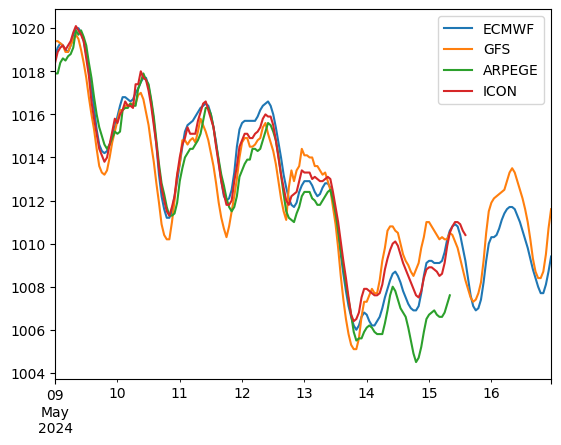

In [ ]:
data_presion_df = pd.DataFrame(index=pd.to_datetime(time))

data_presion_df["ECMWF"] = data.loc[nombre_presion+modelo_europeo]["hourly"]

data_presion_df["GFS"] = data.loc[nombre_presion+modelo_gfs]["hourly"]

data_presion_df["AROME"] = data.loc[nombre_presion+modelo_arome]["hourly"]

data_presion_df["ARPEGE"] = data.loc[nombre_presion+modelo_arpege]["hourly"]

data_presion_df["ICON"] = data.loc[nombre_presion+modelo_icon]["hourly"]




data_presion_df.plot()

<Axes: >

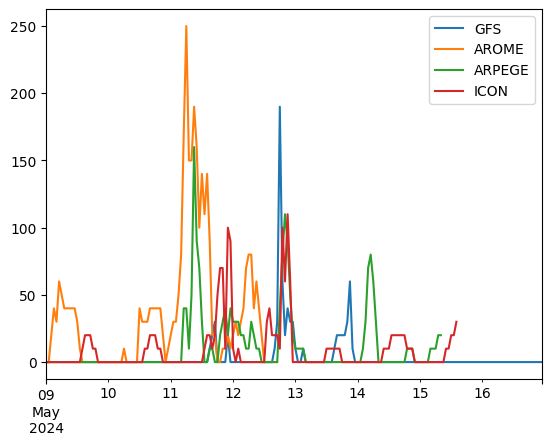

In [ ]:
data_cape_df = pd.DataFrame(index=pd.to_datetime(time))

#data_cape_df["ECMWF"] = data.loc[nombre_cape+modelo_europeo]["hourly"]

data_cape_df["GFS"] = data.loc[nombre_cape+modelo_gfs]["hourly"]

data_cape_df["AROME"] = data.loc[nombre_cape+modelo_arome]["hourly"]

data_cape_df["ARPEGE"] = data.loc[nombre_cape+modelo_arpege]["hourly"]

data_cape_df["ICON"] = data.loc[nombre_cape+modelo_icon]["hourly"]




data_cape_df.plot()

<Axes: >

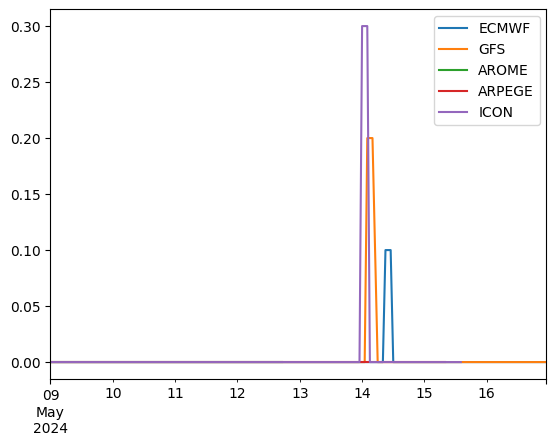

In [ ]:
data_preci_df = pd.DataFrame(index=pd.to_datetime(time))

data_preci_df["ECMWF"] = data.loc[nombre_preci+modelo_europeo]["hourly"]

data_preci_df["GFS"] = data.loc[nombre_preci+modelo_gfs]["hourly"]

data_preci_df["AROME"] = data.loc[nombre_preci+modelo_arome]["hourly"]

data_preci_df["ARPEGE"] = data.loc[nombre_preci+modelo_arpege]["hourly"]

data_preci_df["ICON"] = data.loc[nombre_preci+modelo_icon]["hourly"]




data_preci_df.plot()

<Axes: >

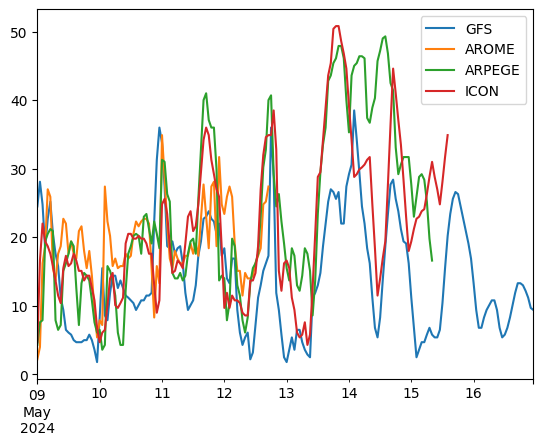

In [ ]:
data_rachas_df = pd.DataFrame(index=pd.to_datetime(time))

#data_rachas_df["ECMWF"] = data.loc[nombre_rachas+modelo_europeo]["hourly"]

data_rachas_df["GFS"] = data.loc[nombre_rachas+modelo_gfs]["hourly"]

data_rachas_df["AROME"] = data.loc[nombre_rachas+modelo_arome]["hourly"]

data_rachas_df["ARPEGE"] = data.loc[nombre_rachas+modelo_arpege]["hourly"]

data_rachas_df["ICON"] = data.loc[nombre_rachas+modelo_icon]["hourly"]




data_rachas_df.plot()

<Axes: >

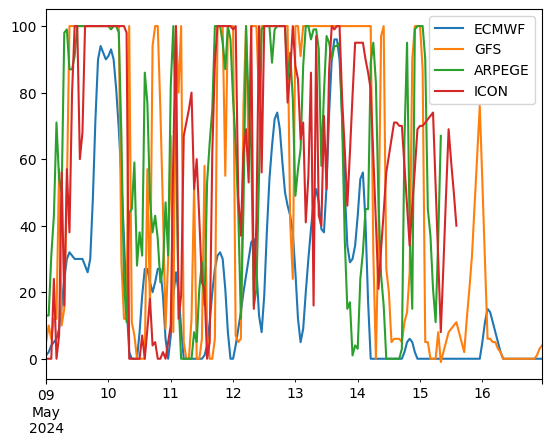

In [ ]:
data_nubes_df = pd.DataFrame(index=pd.to_datetime(time))

data_nubes_df["ECMWF"] = data.loc[nombre_nubes+modelo_europeo]["hourly"]

data_nubes_df["GFS"] = data.loc[nombre_nubes+modelo_gfs]["hourly"]

data_nubes_df["AROME"] = data.loc[nombre_nubes+modelo_arome]["hourly"]

data_nubes_df["ARPEGE"] = data.loc[nombre_nubes+modelo_arpege]["hourly"]

data_nubes_df["ICON"] = data.loc[nombre_nubes+modelo_icon]["hourly"]




data_nubes_df.plot()

<Axes: >

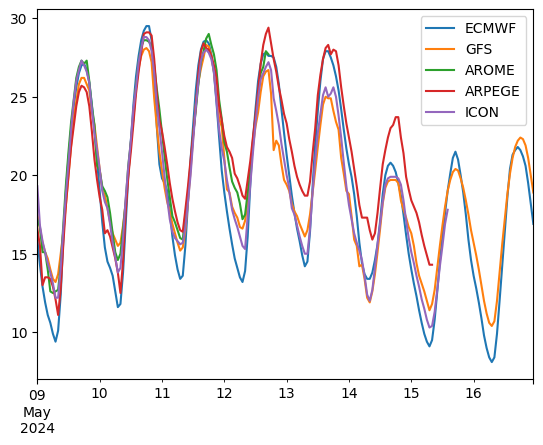

In [ ]:
data_temp_df = pd.DataFrame(index=pd.to_datetime(time))

data_temp_df["ECMWF"] = data.loc[nombre_temp+modelo_europeo]["hourly"]

data_temp_df["GFS"] = data.loc[nombre_temp+modelo_gfs]["hourly"]

data_temp_df["AROME"] = data.loc[nombre_temp+modelo_arome]["hourly"]

data_temp_df["ARPEGE"] = data.loc[nombre_temp+modelo_arpege]["hourly"]

data_temp_df["ICON"] = data.loc[nombre_temp+modelo_icon]["hourly"]

data_temp_df.plot()

In [ ]:
def all_hours_have_data(group):
    return group.notnull().all()


groups = data_temp_df.groupby(data_temp_df.index.date).apply(all_hours_have_data)


data_temp_max = data_temp_df.groupby(data_temp_df.index.date).max() * groups[groups==True]

data_temp_min = data_temp_df.groupby(data_temp_df.index.date).min() * groups[groups==True]


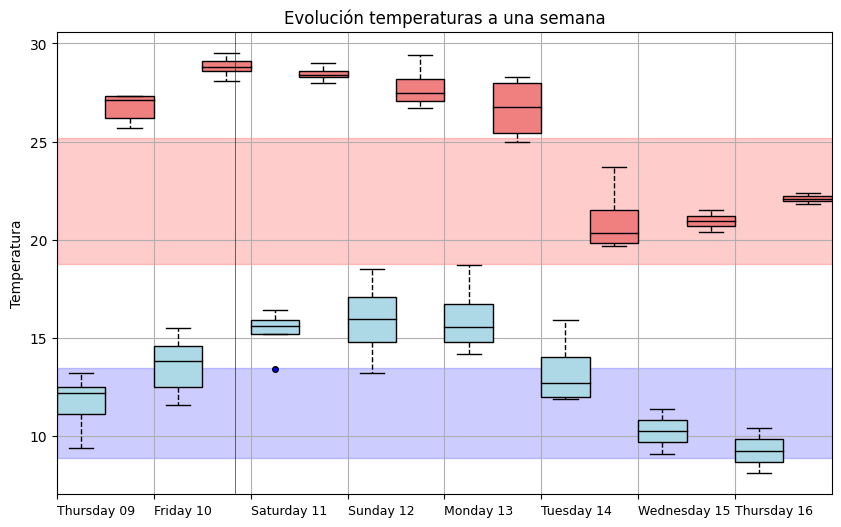

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

day0 = data_temp_min.iloc[0,:].dropna()
day1 = data_temp_min.iloc[1,:].dropna()
day2 = data_temp_min.iloc[2,:].dropna()
day3 = data_temp_min.iloc[3,:].dropna()
day4 = data_temp_min.iloc[4,:].dropna()
day5 = data_temp_min.iloc[5,:].dropna()
day6 = data_temp_min.iloc[6,:].dropna()
day7 = data_temp_min.iloc[7,:].dropna()

data_plotted = [day0,day1,day2,day3,day4,day5,day6,day7]


boxprops =  dict(linewidth=1, color='black', facecolor='lightblue')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='blue', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

plt.boxplot(data_plotted, positions=[0.25,1.25,2.25,3.25,4.25,5.25,6.25,7.25], patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);



day0 = data_temp_max.iloc[0,:].dropna()
day1 = data_temp_max.iloc[1,:].dropna()
day2 = data_temp_max.iloc[2,:].dropna()
day3 = data_temp_max.iloc[3,:].dropna()
day4 = data_temp_max.iloc[4,:].dropna()
day5 = data_temp_max.iloc[5,:].dropna()
day6 = data_temp_max.iloc[6,:].dropna()
day7 = data_temp_max.iloc[7,:].dropna()

data_plotted = [day0,day1,day2,day3,day4,day5,day6,day7]

boxprops =  dict(linewidth=1, color='black', facecolor='lightcoral')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')


plt.boxplot(data_plotted, positions=[0.75,1.75,2.75,3.75,4.75,5.75,6.75,7.75], patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


max_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[0]
max_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[1]

plt.fill_between(data.index,max_usual_temp_upper,max_usual_temp_lower, alpha=0.2, color='red')

min_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[0]
min_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[1]

plt.fill_between(data.index,min_usual_temp_upper,min_usual_temp_lower, alpha=0.2, color='blue')


plt.xlim(0,8)

plt.axvline((datetime.now().hour / 24 + 1),color="black",linewidth=.4)

plt.title("Evolución temperaturas a una semana")
plt.ylabel("Temperatura")

plt.xticks([0,1,2,3,4,5,6,7], pd.to_datetime(data_temp_min.index).strftime('%A %d'),ha="center")
plt.xticks(rotation=0, ha='left', fontsize=9)

plt.grid();

In [ ]:
pd.to_datetime(data_temp_min.index).strftime('%A %d %B')

Index(['Thursday 09 May', 'Friday 10 May', 'Saturday 11 May', 'Sunday 12 May',
       'Monday 13 May', 'Tuesday 14 May', 'Wednesday 15 May',
       'Thursday 16 May'],
      dtype='object')

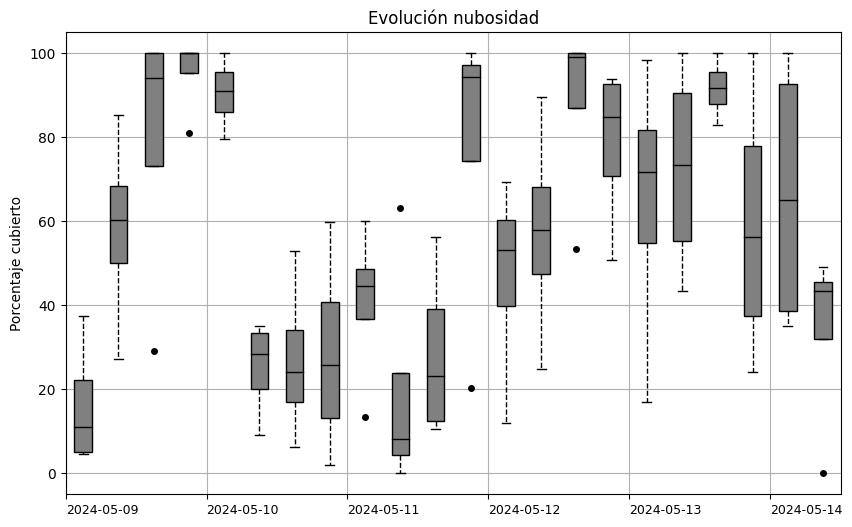

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


data_plotted = data_nubes_df.resample("6H",closed="left",label="left").mean().dropna(axis=1,how="all").T.iloc[:,:-10]


boxprops =  dict(linewidth=1, color='black', facecolor='gray')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='black', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

plt.boxplot(data_plotted, positions=[x+0.5 for x in range(0,len(data_plotted.columns))] , patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


date_list = []
for item in data_plotted.columns.date:
    if item not in date_list:
        date_list.append(item)



plt.xticks([x for x in range(0,len(data_plotted.columns),4)], date_list,ha="center");
plt.xticks(rotation=0, ha='left', fontsize=9);
plt.grid()

plt.title("Evolución nubosidad");
plt.ylabel("Porcentaje cubierto");


In [ ]:
data_preci_df.iloc[50:80]

,ECMWF,GFS,AROME,ARPEGE,ICON
2024-05-11 02:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 03:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 04:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 05:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 06:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 07:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 08:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 09:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 10:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 11:00:00,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_preci_df.resample("6H",closed="left",label="left").mean() * 6

,ECMWF,GFS,AROME,ARPEGE,ICON
2024-05-09 00:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-09 06:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-09 12:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-09 18:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-10 00:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-10 06:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-10 12:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-10 18:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 00:00:00,0.0,0.0,0.0,0.0,0.0
2024-05-11 06:00:00,0.0,0.0,0.0,0.0,0.0


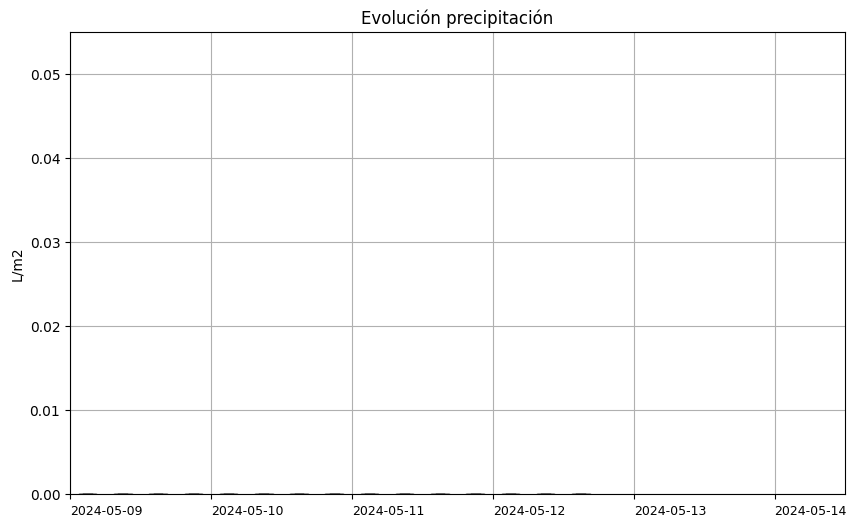

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


data_plotted = data_preci_df.resample("6H",closed="left",label="left").mean().dropna(axis=1,how="all").T.iloc[:,:-10]


boxprops =  dict(linewidth=1, color='black', facecolor='lightblue')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='blue', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

plt.boxplot(data_plotted, positions=[x+0.5 for x in range(0,len(data_plotted.columns))] , patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


date_list = []
for item in data_plotted.columns.date:
    if item not in date_list:
        date_list.append(item)



plt.xticks([x for x in range(0,len(data_plotted.columns),4)], date_list,ha="center");
plt.xticks(rotation=0, ha='left', fontsize=9);
plt.grid()
plt.ylim(0)

plt.title("Evolución precipitación");
plt.ylabel("L/m2");

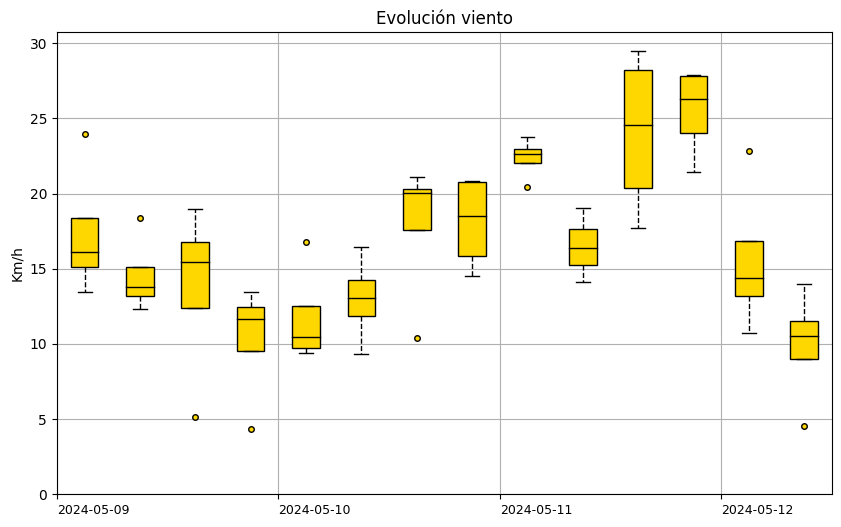

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


data_plotted = data_rachas_df.resample("6H",closed="left",label="left").mean().dropna(axis=1,how="all").T.iloc[:,:-18]


boxprops =  dict(linewidth=1, color='black', facecolor='gold')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='gold', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

plt.boxplot(data_plotted, positions=[x+0.5 for x in range(0,len(data_plotted.columns))] , patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


date_list = []
for item in data_plotted.columns.date:
    if item not in date_list:
        date_list.append(item)



plt.xticks([x for x in range(0,len(data_plotted.columns),4)], date_list,ha="center");
plt.xticks(rotation=0, ha='left', fontsize=9);
plt.grid()
plt.ylim(0)

plt.title("Evolución viento");
plt.ylabel("Km/h");

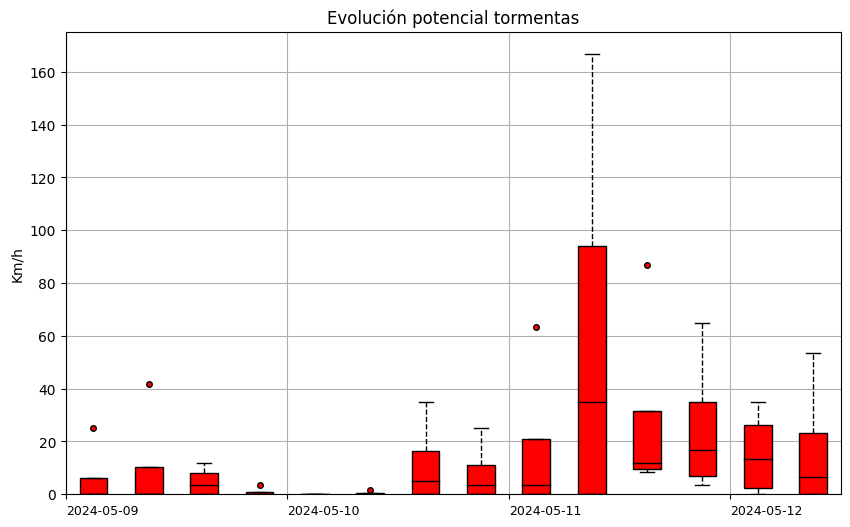

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


data_plotted = data_cape_df.resample("6H",closed="left",label="left").mean().dropna(axis=1,how="all").T.iloc[:,:-18]


boxprops =  dict(linewidth=1, color='black', facecolor='red')
whiskerprops = dict(linewidth=1, color='black',linestyle='dashed')
flierprops = dict(marker='o', markerfacecolor='red', markersize=4, linestyle='none')
medianprops = dict(linewidth=1, color='black')

plt.boxplot(data_plotted, positions=[x+0.5 for x in range(0,len(data_plotted.columns))] , patch_artist=True,boxprops=boxprops, 
            whiskerprops=whiskerprops,flierprops=flierprops,medianprops=medianprops);


date_list = []
for item in data_plotted.columns.date:
    if item not in date_list:
        date_list.append(item)



plt.xticks([x for x in range(0,len(data_plotted.columns),4)], date_list,ha="center");
plt.xticks(rotation=0, ha='left', fontsize=9);
plt.grid()
plt.ylim(0)

plt.title("Evolución potencial tormentas");
plt.ylabel("Km/h");

In [ ]:

def get_ensemble_data(url):


    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_last_ecmwf_run():

    runs = [0,12]
    url ='https://www.meteociel.com/modeles/ecmwfens_table.php?x=0&y=0&lat=40.41&lon=-3.61&ext=1&mode=13&sort=0'

    last_index = pd.Timestamp(year=2023, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        last_index_run = get_arome_data(url_run).index[-1]

        if last_index_run > last_index:
            last_index = last_index_run
            valid_run = run
        else:
            pass

    return valid_run

def get_last_gfs_run():

    runs = [0,6,12,18]
    url ='https://www.meteociel.fr/modeles/gefs_table.php?x=0&y=0&lat=40.41&lon=-3.658&ext=1&mode=23&sort=0'

    last_index = pd.Timestamp(year=2023, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        last_index_run = get_arome_data(url_run).index[-1]

        if last_index_run > last_index:
            last_index = last_index_run
            valid_run = run
        else:
            pass

    return valid_run



valid_run_ecmwf = get_last_ecmwf_run()

valid_run_gfs = get_last_gfs_run()


def get_prec_data_ecmwf(valid_run):

    url ='https://www.meteociel.com/modeles/ecmwfens_table.php?x=0&y=0&lat=40.41&lon=-3.61&ext=1&mode=3&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


def get_prec_data_gfs(valid_run):

    url ='https://www.meteociel.fr/modeles/gefs_table.php?x=0&y=0&lat=40.41&lon=-3.658&ext=1&mode=3&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data





In [ ]:
(get_prec_data_gfs(valid_run).resample("1H").mean().resample("6H").mean() * 6).plot()

AttributeError: 'NoneType' object has no attribute 'find_all'

In [ ]:
get_prec_data_gfs(valid_run).plot()

AttributeError: 'NoneType' object has no attribute 'find_all'

<Axes: xlabel='Date'>

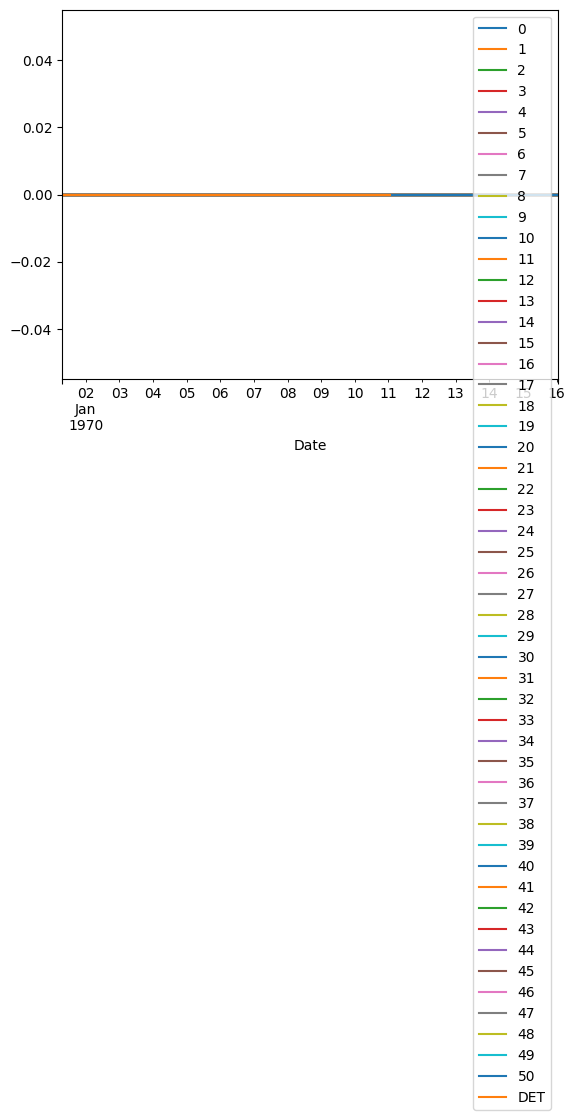

In [ ]:
get_prec_data_ecmwf(valid_run).plot()